In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import phik  
warnings.filterwarnings('ignore') 
# Methods
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 15)

In [3]:
store=pd.read_csv('store.csv')

In [4]:
bank=pd.read_csv('bank_train.csv')
bank_test=pd.read_csv('bank_test.csv')

In [5]:
bank_test = bank_test.drop(['id'], axis=1)

# Bank Data Anlaysis

# bank data EDA

In [13]:
import sweetviz as sv
report = sv.analyze(bank, target_feat='subscribed')
report.show_html()


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## data overview and type categorisation 

In [6]:
from dabl import detect_types
types = detect_types(bank)
types

,continuous,dirty_float,low_card_int,categorical,date,free_string,useless
age,False,False,True,False,False,False,False
job,False,False,False,True,False,False,False
marital,False,False,False,True,False,False,False
education,False,False,False,True,False,False,False
default,False,False,False,False,False,False,True
balance,True,False,False,False,False,False,False
housing,False,False,False,True,False,False,False
loan,False,False,False,True,False,False,False
contact,False,False,False,True,False,False,False
day,False,False,True,False,False,False,False


In [36]:
continuous_b = ['age','balance','pdays','campaign','previous','day']
categorical_b =['job','contact','education','month','marital','poutcome']
binary_b =['default','loan','housing']
response_b =['subscribed']

In [9]:
bank['subscribed'].value_counts(normalize=True)

no     0.883009
yes    0.116991
Name: subscribed, dtype: float64

Text(0.5, 1.0, 'Subscribed distribution')

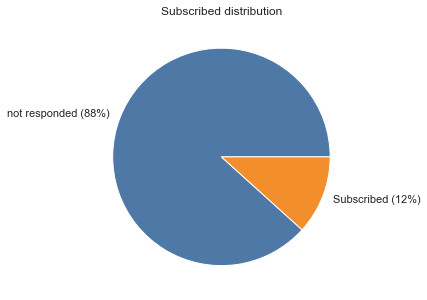

In [10]:
df1=bank['subscribed'].value_counts()
plt.figure(figsize=(5,5))
label=['not responded (88%)','Subscribed (12%)']
plt.pie(df1.values,labels=label)
plt.title('Subscribed distribution')

<Figure size 1440x1440 with 0 Axes>

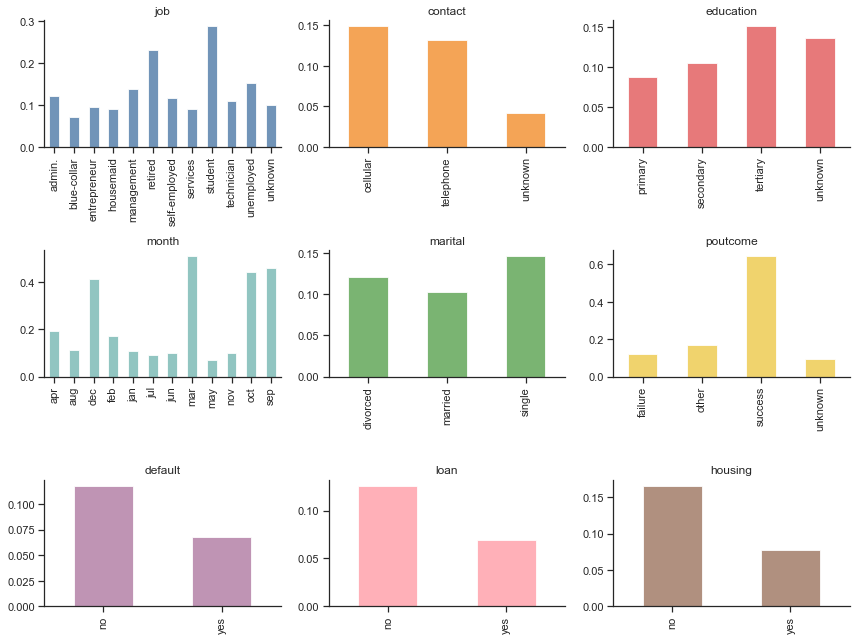

In [11]:
from tutorial4 import crosstabplots
plt.figure(figsize=(20,20))
# IMPORTANT : crosstabplots should only be done for discrete/categorical variables
crossplot_var =['job','contact','education','month','marital','poutcome','default','loan','housing']
crosstabplots(bank[crossplot_var], bank['subscribed'])
plt.show()

In [141]:
df_num = bank.select_dtypes(include = ['int64'])
df_categorical = bank.select_dtypes(include = ['O'])

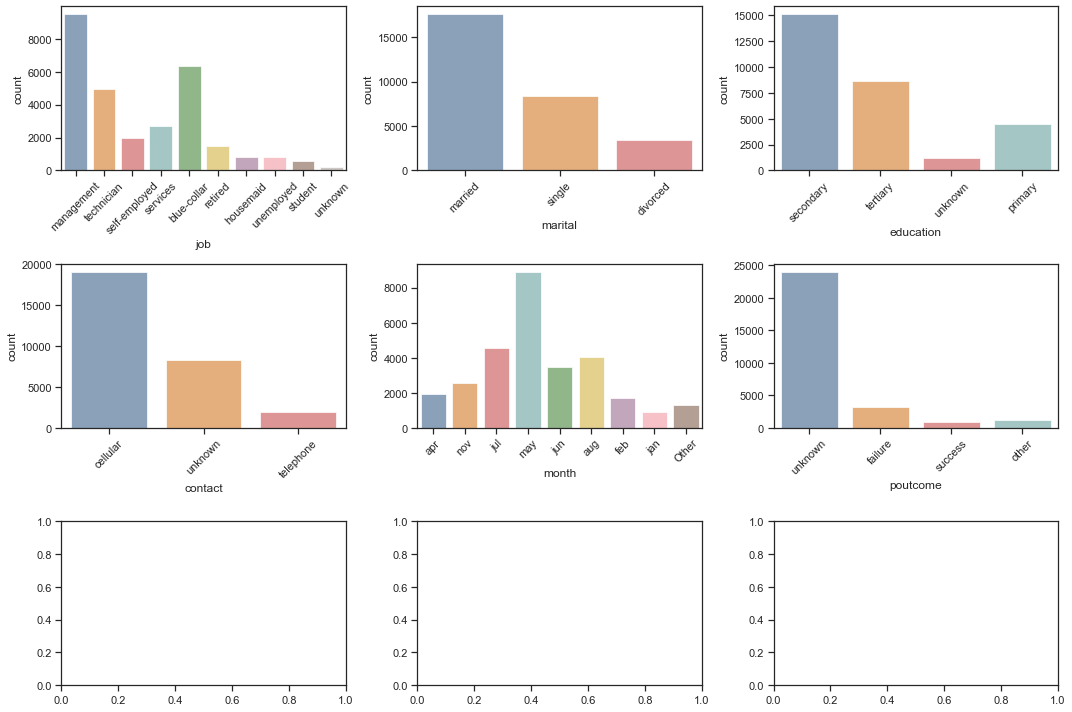

In [142]:
# look at the count categorical variables

fig, axes = plt.subplots(3, 3, figsize=(15,10))

for i, ax in enumerate(fig.axes):
    if i < len(df_categorical.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_categorical.columns[i], alpha=0.7, data=df_categorical, ax=ax)

fig.tight_layout()

comparison and observation between crosstabplots and distribution plots;Although poutcome has a very high unknown, however, we cannot imputate it or categorise it, because it has siginficant difference in terms of impact to others. Hence we leave it as unknown (like a second other category);This measure the amount propotion of subscriber in each categories, maybe we can invest furtherer into no loan,no housing, and successful poutcome, 

# Measures of dependence

phi-k

In [35]:
bank.phik_matrix(interval_cols = continuous_b)['subscribed'].sort_values(ascending=False).round(3)

subscribed    1.000
poutcome      0.451
month         0.327
pdays         0.250
housing       0.212
age           0.202
job           0.177
previous      0.122
education     0.110
loan          0.100
day           0.099
contact       0.089
campaign      0.063
balance       0.053
marital       0.036
default       0.030
Name: subscribed, dtype: float64

Because the repsone variable is non-continous, hence we adopt the Phi-k correlation.This measures the distance between the joint distribution and the product of the marginal distributions. As we can see, period and poutcome has the highest dependence with our response variable subscribed.

In [37]:
mi = mutual_info_classif(bank[continuous_b], bank['subscribed'], random_state=1)
continuous_results_b = pd.DataFrame(mi, index=continuous_b, columns=['MI'])

As correlation only works with linera relationship, hence we should consider about ‘mutual information'. Hence we are doing this separately for continous and discrete predictions.We have to separate continuous from categorical variables and concatenate them togther afterward.

In [40]:
from sklearn.preprocessing import OrdinalEncoder
features = OrdinalEncoder().fit_transform(bank[crossplot_var])

mi = mutual_info_classif(features, bank['subscribed'], n_neighbors=5, 
                         random_state=1, discrete_features=True)

cat_results_b= pd.DataFrame(mi, index=crossplot_var, columns=['MI'])

In [41]:
results = pd.concat([continuous_results_b, cat_results_b], axis=0).sort_values(by='MI', ascending=False).round(4)
results.round(4)

,MI
poutcome,0.0280
pdays,0.0268
month,0.0233
balance,0.0184
age,0.0131
contact,0.0130
previous,0.0109
housing,0.0093
job,0.0085
day,0.0032


## Bank data Feature engineering 

Sparse categories

encode binary data
sparse categorise #month for sep oct mar dec into others
categorise #poutcome as another others
create dummy for '0' in #balance
change '-1' to '0' in #pdays and create dummy for 0s 
create dummy for '0' i #previous

In [75]:
#sparse categorise month accordinng to low population and equal impact for SEP, OCT, MAR, and DEC
variable='month'
counts = bank['month'].value_counts() 
for level in counts.index:
    if counts[level] < 500:
        bank.loc[bank[variable]==level, variable] = 'Other'        

In [76]:
bank_test.loc[(bank_test['month'] == 'sep')|(bank_test['month'] == 'oct')|(bank_test['month'] == 'mar')|(bank_test['month'] == 'dec'), 'month'] = 'Other'

In [77]:
#join management with admin
bank['job'] = bank['job'].replace(['admin.', 'entrepreneur'], ['management', 'self-employed'])
bank_test['job'] = bank_test['job'].replace(['admin.', 'entrepreneur'], ['management', 'self-employed'])

In [78]:
# encode binary data 'default','loan','housing'
bank['default'] = bank['default'].replace(['yes','no'],[1,0])
bank_test['default'] = bank_test['default'].replace(['yes','no'],[1,0])

In [79]:
bank['loan'] = bank['loan'].replace(['yes','no'],[1,0])
bank_test['loan'] = bank_test['loan'].replace(['yes','no'],[1,0])

In [80]:
bank['housing'] = bank['housing'].replace(['yes','no'],[1,0])
bank_test['housing'] = bank_test['housing'].replace(['yes','no'],[1,0])

In [81]:
bank['housing'] = bank['housing'].replace(['yes','no'],[1,0])
bank_test['housing'] =bank_test['housing'].replace(['yes','no'],[1,0])

In [82]:
#change -1 to a large number
bank['pdays'] = bank['pdays'].replace([-1],9999)
bank_test['pdays'] = bank_test['pdays'].replace([-1],9999)

In [83]:
#Convert subscribed into a dummy variable
bank['subscribed'] = bank['subscribed'].replace(['yes','no'],[1,0])

In [84]:
#create a dummy variable list for balance =0, we will add that after transformation 
zero_balance=[]
for level in range(bank['balance'].value_counts().sum()):
    if bank['balance'].iloc[level]==0:
        zero_balance.append(1)
    else: 
        zero_balance.append(0)
bank['zero_balance']=zero_balance

In [85]:
zero_balance_test =[]
for level in range(bank_test['balance'].value_counts().sum()):
    if bank_test['balance'].iloc[level]==0:
        zero_balance_test.append(1)
    else: 
        zero_balance_test.append(0)
bank_test['zero_balance']=zero_balance_test

In [86]:
#create dummy variable when pday=0
zero_pdays=[]
for level in range(bank['pdays'].value_counts().sum()):
    if bank['pdays'].iloc[level]==0:
        zero_pdays.append(1)
    else: 
        zero_pdays.append(0)
bank['zero_pdays']=zero_pdays

In [87]:
zero_pdays_test=[]
for level in range(bank_test['pdays'].value_counts().sum()):
    if bank_test['pdays'].iloc[level]==0:
        zero_pdays_test.append(1)
    else: 
        zero_pdays_test.append(0)
bank_test['zero_pdays']=zero_pdays_test

In [88]:
#create dummy for '0' in previous
zero_previous=[]
for level in range(bank['previous'].value_counts().sum()):
    if bank['previous'].iloc[level]==0:
        zero_previous.append(1)
    else: 
        zero_previous.append(0)
bank['zero_previous']=zero_previous

In [89]:
zero_previous_test=[]
for level in range(bank_test['previous'].value_counts().sum()):
    if bank_test['previous'].iloc[level]==0:
        zero_previous_test.append(1)
    else: 
        zero_previous_test.append(0)
bank_test['zero_previous']=zero_previous_test

In [90]:
bank['age_bal']=bank['age']*bank['balance']
bank['hous_loan']=bank['housing']*bank['loan']
bank_test['age_bal']=bank_test['age']*bank_test['balance']
bank_test['hous_loan']=bank_test['housing']*bank_test['loan']

'''
X_valid['job_edu']=X_valid['job']*X_valid['education']
X_valid['mar_hous']=X_valid['marital']*X_valid['housing']
X_valid['mar_loan']=X_valid['marital']*X_valid['loan']'''

"\nX_valid['job_edu']=X_valid['job']*X_valid['education']\nX_valid['mar_hous']=X_valid['marital']*X_valid['housing']\nX_valid['mar_loan']=X_valid['marital']*X_valid['loan']"

In [91]:
bank_index_train,bank_index_valid  = train_test_split(bank.index, train_size=0.75,random_state=96, stratify=bank['subscribed'])

# Write training and validation sets 
bank_train = bank.loc[index_train, :].copy() 
bank_valid =  bank.loc[index_valid, :].copy()

# Response label
response = 'subscribed'

# Response vectors 
bank_y_train = train[response_b]
bank_y_valid = valid[response_b]

we decide to split the bank training data into traininng and validation data, so we can compare our result against kaggle result to detect and reduce overfitting. 

In [92]:
continuous_b = ['age','balance','pdays','campaign','previous']
categorical_b =['job','month','poutcome']
binary_b =['default','loan','housing','zero_balance','zero_pdays','zero_previous'] #'zero_balance','zero_pdays','zero_previous'
response_b =['subscribed']

In [94]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

def feat_engineering(df, transformation=True):
    
    data = df.copy()
    
    # Dummy encoding or discrete and categorical variables
    dummies = binary_b[:] # copies list of binary predictors
    labels =categorical_b
    for label in labels:
        features = pd.get_dummies(data[label], prefix=label, drop_first=True)
        data = pd.concat([data,features], axis=1)
        dummies += list(features.columns)
    
    # Yeo-Johnson transformation
    transf = continuous_b
    if transformation: 
        yj_transf = PowerTransformer(method='yeo-johnson').fit(data.loc[index_train, transf])
        data[transf] = yj_transf.transform(data.loc[:, transf])
    
    # Standardisation
    labels = continuous_b
    scaler = StandardScaler().fit(data.loc[index_train, labels])
    data.loc[:, labels] = scaler.transform(data.loc[:, labels])
    
    predictors = continuous_b + dummies
    
    bank_X_train = data.loc[bank_index_train, predictors]
    bank_X_valid = data.loc[bank_index_valid, predictors]

    bank_y_train = data.loc[bank_index_train, bank_response].to_numpy()
    bank_y_valid = data.loc[bank_index_valid, bank_response].to_numpy()
    
    return bank_X_train, np.ravel(bank_y_train), bank_X_valid, np.ravel(bank_y_valid), predictors

bank_X_train, bank_y_train, bank_X_valid, bank_y_bankvalid, predictors = feat_engineering(bank)

we perform transformation and standardise data on the training and validation data. 

In [116]:
def feat_engineering(test, transformation=True):
    
    test = test.copy()
    
    # Dummy encoding or discrete and categorical variables
    dummies = binary_b[:] # copies list of binary predictors
    labels =categorical_b
    for label in labels:
        features = pd.get_dummies(test[label], prefix=label, drop_first=True)
        test = pd.concat([test,features], axis=1)
        dummies += list(features.columns)
    
    # Yeo-Johnson transformation
    transf = continuous_b
    if transformation: 
        yj_transf = PowerTransformer(method='yeo-johnson').fit(test.loc[:, transf])
        test[transf] = yj_transf.transform(test.loc[:, transf])
    
    # Standardisation
    labels = continuous_b
    scaler = StandardScaler().fit(test.loc[:, labels])
    test.loc[:, labels] = scaler.transform(test.loc[:, labels])
    
    predictors = continuous_b + dummies
    
    bank_X_trainval= test.loc[:, predictors]
    bank_y_trainval = test.loc[:, bank_response].to_numpy()
    #y_test = test.loc[:, response].to_numpy()
        
    return bank_X_trainval,bank_y_trainval,predictors

bank_X_trainval, bank_y_trainval,predictors = feat_engineering(bank)

we aslo produce a complete data so we can use it to predict with test data

In [ ]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

def feat_engineering(test, transformation=True):
    
    test = test.copy()
    
    # Dummy encoding or discrete and categorical variables
    dummies = binary_b[:] # copies list of binary predictors
    labels =categorical_b
    for label in labels:
        features = pd.get_dummies(test[label], prefix=label, drop_first=True)
        test = pd.concat([test,features], axis=1)
        dummies += list(features.columns)
    
    # Yeo-Johnson transformation
    transf = continuous_b
    if transformation: 
        yj_transf = PowerTransformer(method='yeo-johnson').fit(test.loc[:, transf])
        test[transf] = yj_transf.transform(test.loc[:, transf])
    
    # Standardisation
    labels = continuous_b
    scaler = StandardScaler().fit(test.loc[:, labels])
    test.loc[:, labels] = scaler.transform(test.loc[:, labels])
    
    predictors = continuous_b + dummies
    
    X_bank_test = test.loc[:, predictors]
    
    #y_test = test.loc[:, response].to_numpy()
        
    return X_bank_test, predictors

X_bank_test, predictors = feat_engineering(bank_test)

and a transformation for our test set so we can use the x data to predict reponse value

## Model Building 

l2 model with regulation

train vs validation set

In [118]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='l1', solver='liblinear') # using a different solver to avoid numerical errors
x1=logit.fit(bank_X_train, bank_y_train)
#+l1 pentaly
#try the logitic regression 

Comparing metrics result 

In [119]:
tau=0.5

In [120]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, log_loss
from sklearn.metrics import accuracy_score

columns=['Estimated risk', 'SE', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Logistic Regression']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit]

y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):    
    
    y_prob[:,i] = method.predict_proba(X_valid)[:,1]
    y_pred = (y_prob[:,i] > tau).astype(int)

    loss =  5*((y_pred!=y_valid) & (y_pred==0)) + 1*((y_pred!=y_valid) & (y_pred==1))

    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*5)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(loss))
    results.iloc[i,2] =  accuracy_score(y_valid, y_pred)
    results.iloc[i,3] =  tp/(tp+fn)
    results.iloc[i,4] =  tn/(tn+fp)
    results.iloc[i,5] =  precision_score(y_valid, y_pred)
    results.iloc[i,6] =  roc_auc_score(y_valid, y_prob[:,i])
    results.iloc[i,7] =  log_loss(y_valid, y_prob[:,i])

results.round(3)

,Estimated risk,SE,Accuracy,Sensitivity,Specificity,Precision,AUC,Cross-entropy
Logistic Regression,0.514,0.039,0.892,0.134,0.992,0.697,0.699,0.319


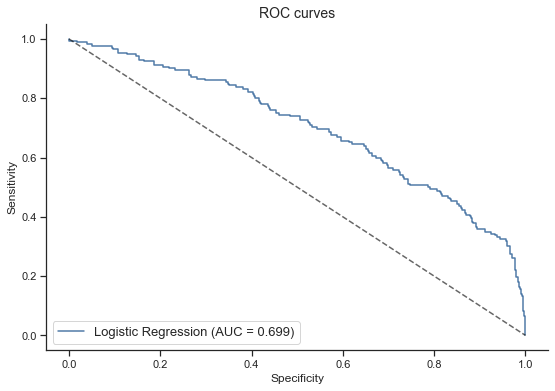

In [121]:
from tutorial4 import rocplot
fig, ax = rocplot(y_valid, y_prob, labels=pd.Series(rows))
plt.show()

prediction on the test set 

In [126]:
logit = LogisticRegression(penalty='l1', solver='liblinear') # using a different solver to avoid numerical errors
x1=logit.fit(bank_X_train, bank_y_train)
pred_test =logit.predict(X_bank_test) 

In [129]:
#save and test on Kaggle
pd.DataFrame(pred_test).to_csv("kaggle prediction.csv")

# Store Data Anlaysis

## Store data EDA

In [ ]:
import sweetviz as sv

report = sv.analyze(store, target_feat='RESP')
report.show_html()

data overview and type categorisation 

In [146]:
from dabl import detect_types
types = detect_types(store)
types

,continuous,dirty_float,low_card_int,categorical,date,free_string,useless
ZIP_CODE,True,False,False,False,False,False,False
FRE,False,False,True,False,False,False,False
MON,True,False,False,False,False,False,False
CC_CARD,False,False,False,True,False,False,False
AVRG,True,False,False,False,False,False,False
PC_CALC20,False,False,True,False,False,False,False
PSWEATERS,True,False,False,False,False,False,False
PKNIT_TOPS,True,False,False,False,False,False,False
PKNIT_DRES,True,False,False,False,False,False,False
PBLOUSES,True,False,False,False,False,False,False


In [147]:
continuous_s=['ZIP_CODE','FRE','MON','AVRG','PSWEATERS','PKNIT_TOPS','PKNIT_DRES','PBLOUSES','PJACKETS','PCAR_PNTS','PCAS_PNTS','PSHIRTS',
            'PDRESSES','PSUITS','POUTERWEAR','PJEWELRY','PFASHION','PLEGWEAR','PCOLLSPND','AMSPEND','PSSPEND','CCSPEND','AXSPEND','TMONSPEND',
            'OMONSPEND','SMONSPEND','PREVPD','GMP','DAYS','FREDAYS','MARKDOWN','CLASSES','STYLES','RESPONSERATE','HI',
            'LTFREDAY','PERCRET']
discrete_s=['PC_CALC20','PROMOS','MAILED','RESPONDED','CLUSTYPE','STORES','COUPONS']
binary_s=['CC_CARD','VALPHON','WEB']
response_s=['RESP']

we categorise the variable according to the frequencies and property listed above. Despite the labling of useless still included in 'WEB' as it very important to a email respond

In [148]:
store['RESP'].value_counts(normalize=True)

0    0.833901
1    0.166099
Name: RESP, dtype: float64

Text(0.5, 1.0, 'RESP distribution')

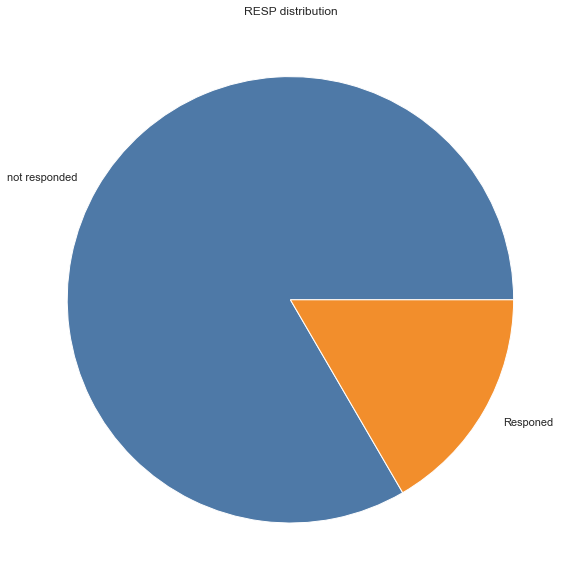

In [61]:
df=store['RESP'].value_counts()
label=['not responded','Responed']
plt.pie(df.values,labels=label)
plt.title('RESP distribution')

we observe a similar trend to the reponse variable in bank dataset


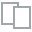
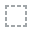
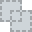
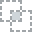
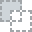
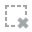
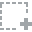
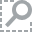
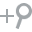
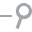
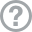
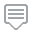
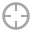
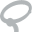
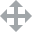
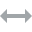
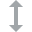
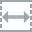
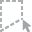
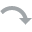
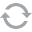
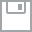
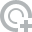
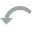
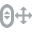
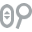
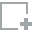
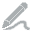
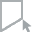
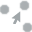
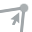
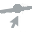

In [153]:
from dataprep.eda import plot

plot(store[continuous_s])

<Figure size 1800x1800 with 0 Axes>

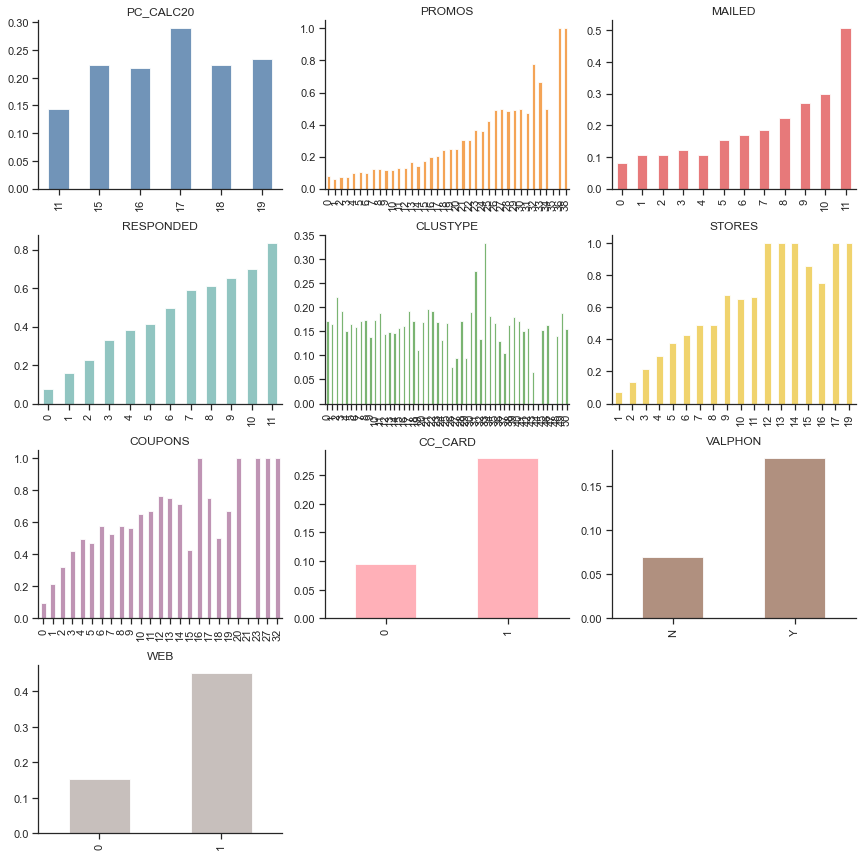

In [193]:
from tutorial4 import crosstabplots
plt.figure(figsize=(25,25))
# IMPORTANT : crosstabplots should only be done for discrete/categorical variables
crosstabplots(store[discrete_s + binary_s], store['RESP'])
plt.show()

<AxesSubplot:title={'center':'CC_CARD'}, xlabel='CC_CARD', ylabel='count'>

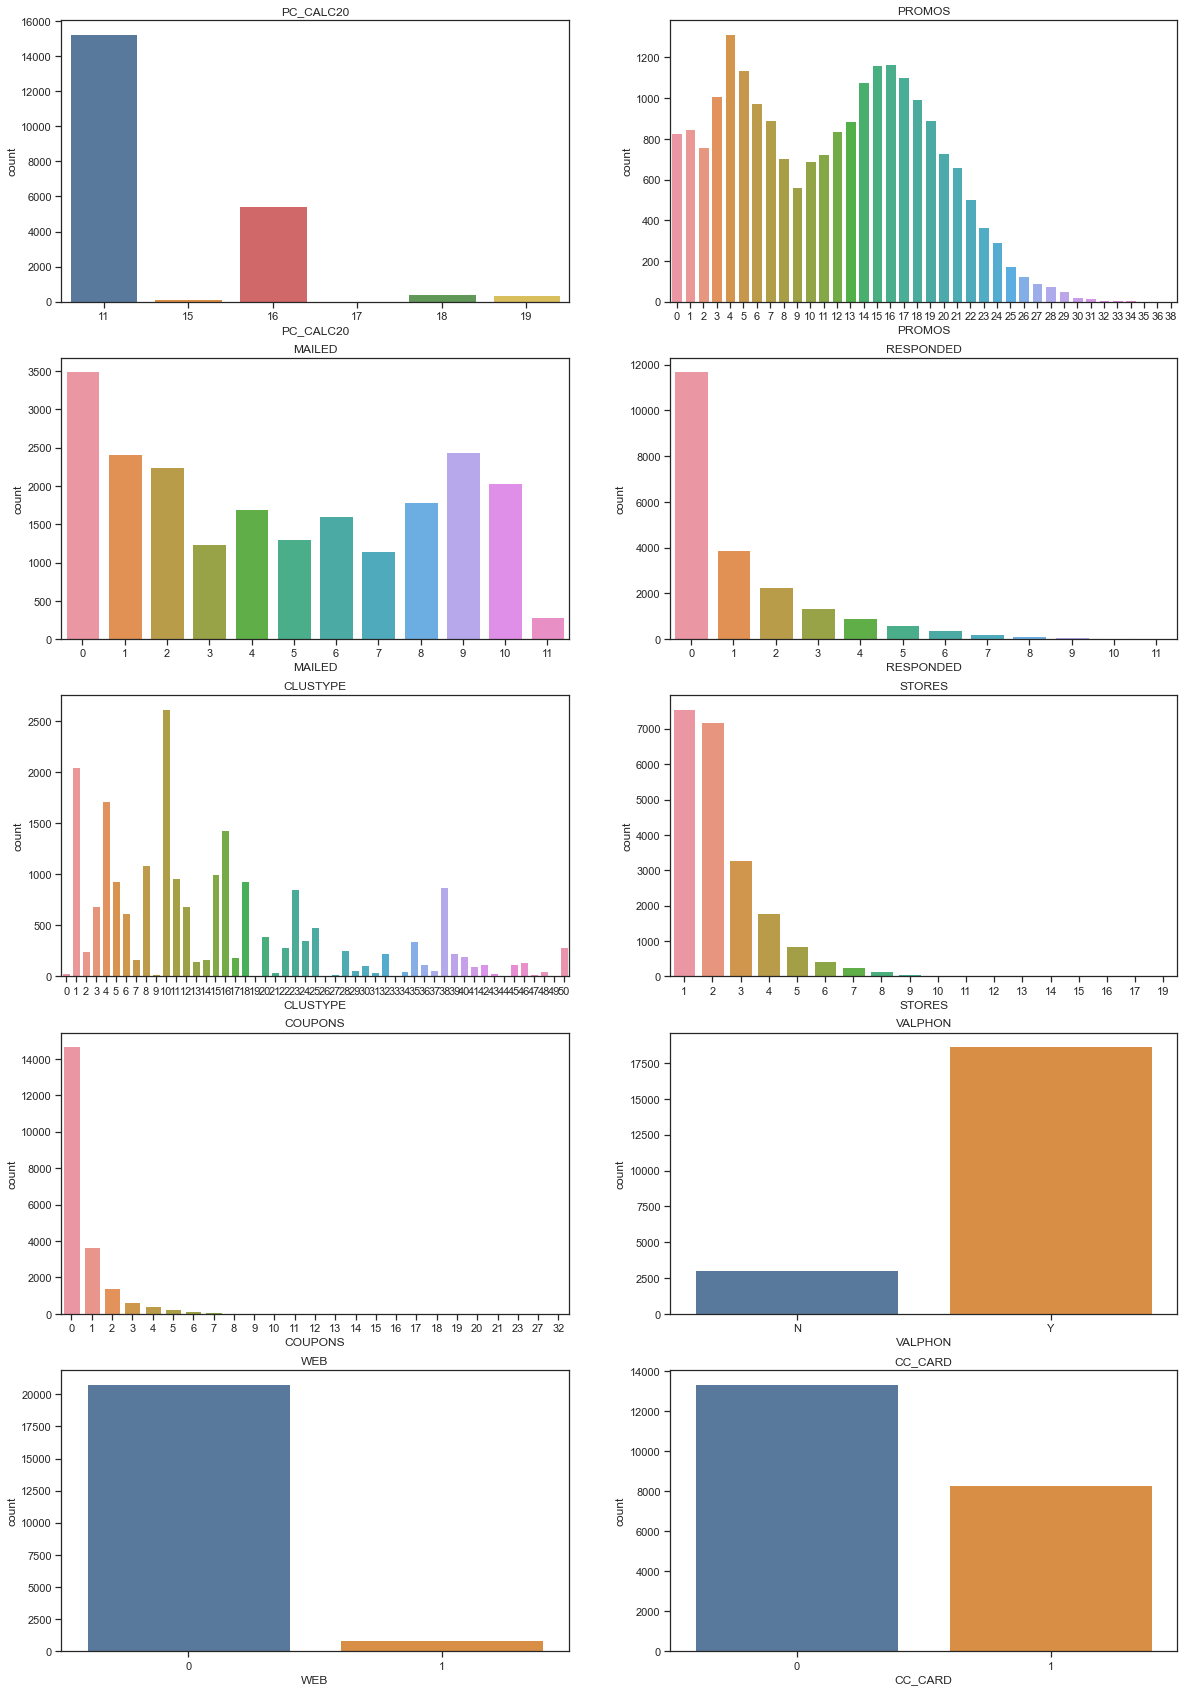

In [201]:
fig, axs = plt.subplots(5, 2,figsize=(20,30))
sns.countplot(store[discrete_s[0]])
plt.title(discrete_s[0])
plt.subplot(5,2,1)
for i in range(len(discrete_s)):
    sns.countplot(store[discrete_s[i]])
    plt.title(discrete_s[i])
    plt.subplot(5,2,i+2)
for i in range(1,len(binary_s)):
    sns.countplot(store[binary_s[i]])
    plt.title(binary_s[i])
    plt.subplot(5,2,i+8)
sns.countplot(store[binary_s[0]])
plt.title(binary_s[0])
plt.subplot(5,2,10)

this shows the distribution of all the continous variable, as we can see most of them are right skewned, and require transformation 

# Measures of dependence

Phi-K value

In [62]:
store.phik_matrix(interval_cols = continuous_s)['RESP'].sort_values(ascending=False).round(3)

RESP            1.000
LTFREDAY        0.512
CLASSES         0.480
RESPONDED       0.452
RESPONSERATE    0.450
FREDAYS         0.401
STORES          0.387
COUPONS         0.382
HI              0.370
CC_CARD         0.370
FRE             0.348
STYLES          0.322
PROMOS          0.305
MAILED          0.288
DAYS            0.262
WEB             0.248
MON             0.240
PJACKETS        0.213
PSWEATERS       0.203
OMONSPEND       0.200
VALPHON         0.162
PSSPEND         0.162
TMONSPEND       0.159
SMONSPEND       0.153
GMP             0.150
MARKDOWN        0.141
PREVPD          0.138
PCAR_PNTS       0.135
PC_CALC20       0.130
PDRESSES        0.112
AXSPEND         0.111
PBLOUSES        0.105
PSHIRTS         0.105
PCOLLSPND       0.102
PCAS_PNTS       0.095
PSUITS          0.091
CCSPEND         0.089
AMSPEND         0.068
POUTERWEAR      0.067
PKNIT_DRES      0.066
ZIP_CODE        0.056
AVRG            0.050
PKNIT_TOPS      0.046
PFASHION        0.040
PJEWELRY        0.023
PERCRET   

Because the repsone variable is non-continous, hence we adopt the Phi-k correlation.This measures the distance between the joint distribution and the product of the marginal distributions.

Mutal Information

In [66]:
mi = mutual_info_classif(store[continuous_s], store['RESP'], random_state=1)
continuous_results = pd.DataFrame(mi, index=continuous_s, columns=['MI'])

In [70]:
features = OrdinalEncoder().fit_transform(store[discrete_s + binary_s])

mi = mutual_info_classif(features, store['RESP'], n_neighbors=5, 
                         random_state=1, discrete_features=True)

cat_results= pd.DataFrame(mi, index=discrete_s + binary_s, columns=['MI'])

In [68]:
results = pd.concat([continuous_results, cat_results], axis=0).sort_values(by='MI', ascending=False).round(4)
results.round(4)

,MI
LTFREDAY,0.1062
FRE,0.0806
STYLES,0.0769
FREDAYS,0.0654
CLASSES,0.0620
MON,0.0552
RESPONSERATE,0.0541
RESPONDED,0.0537
SMONSPEND,0.0515
HI,0.0473


Correlation Table between each contiunous variables

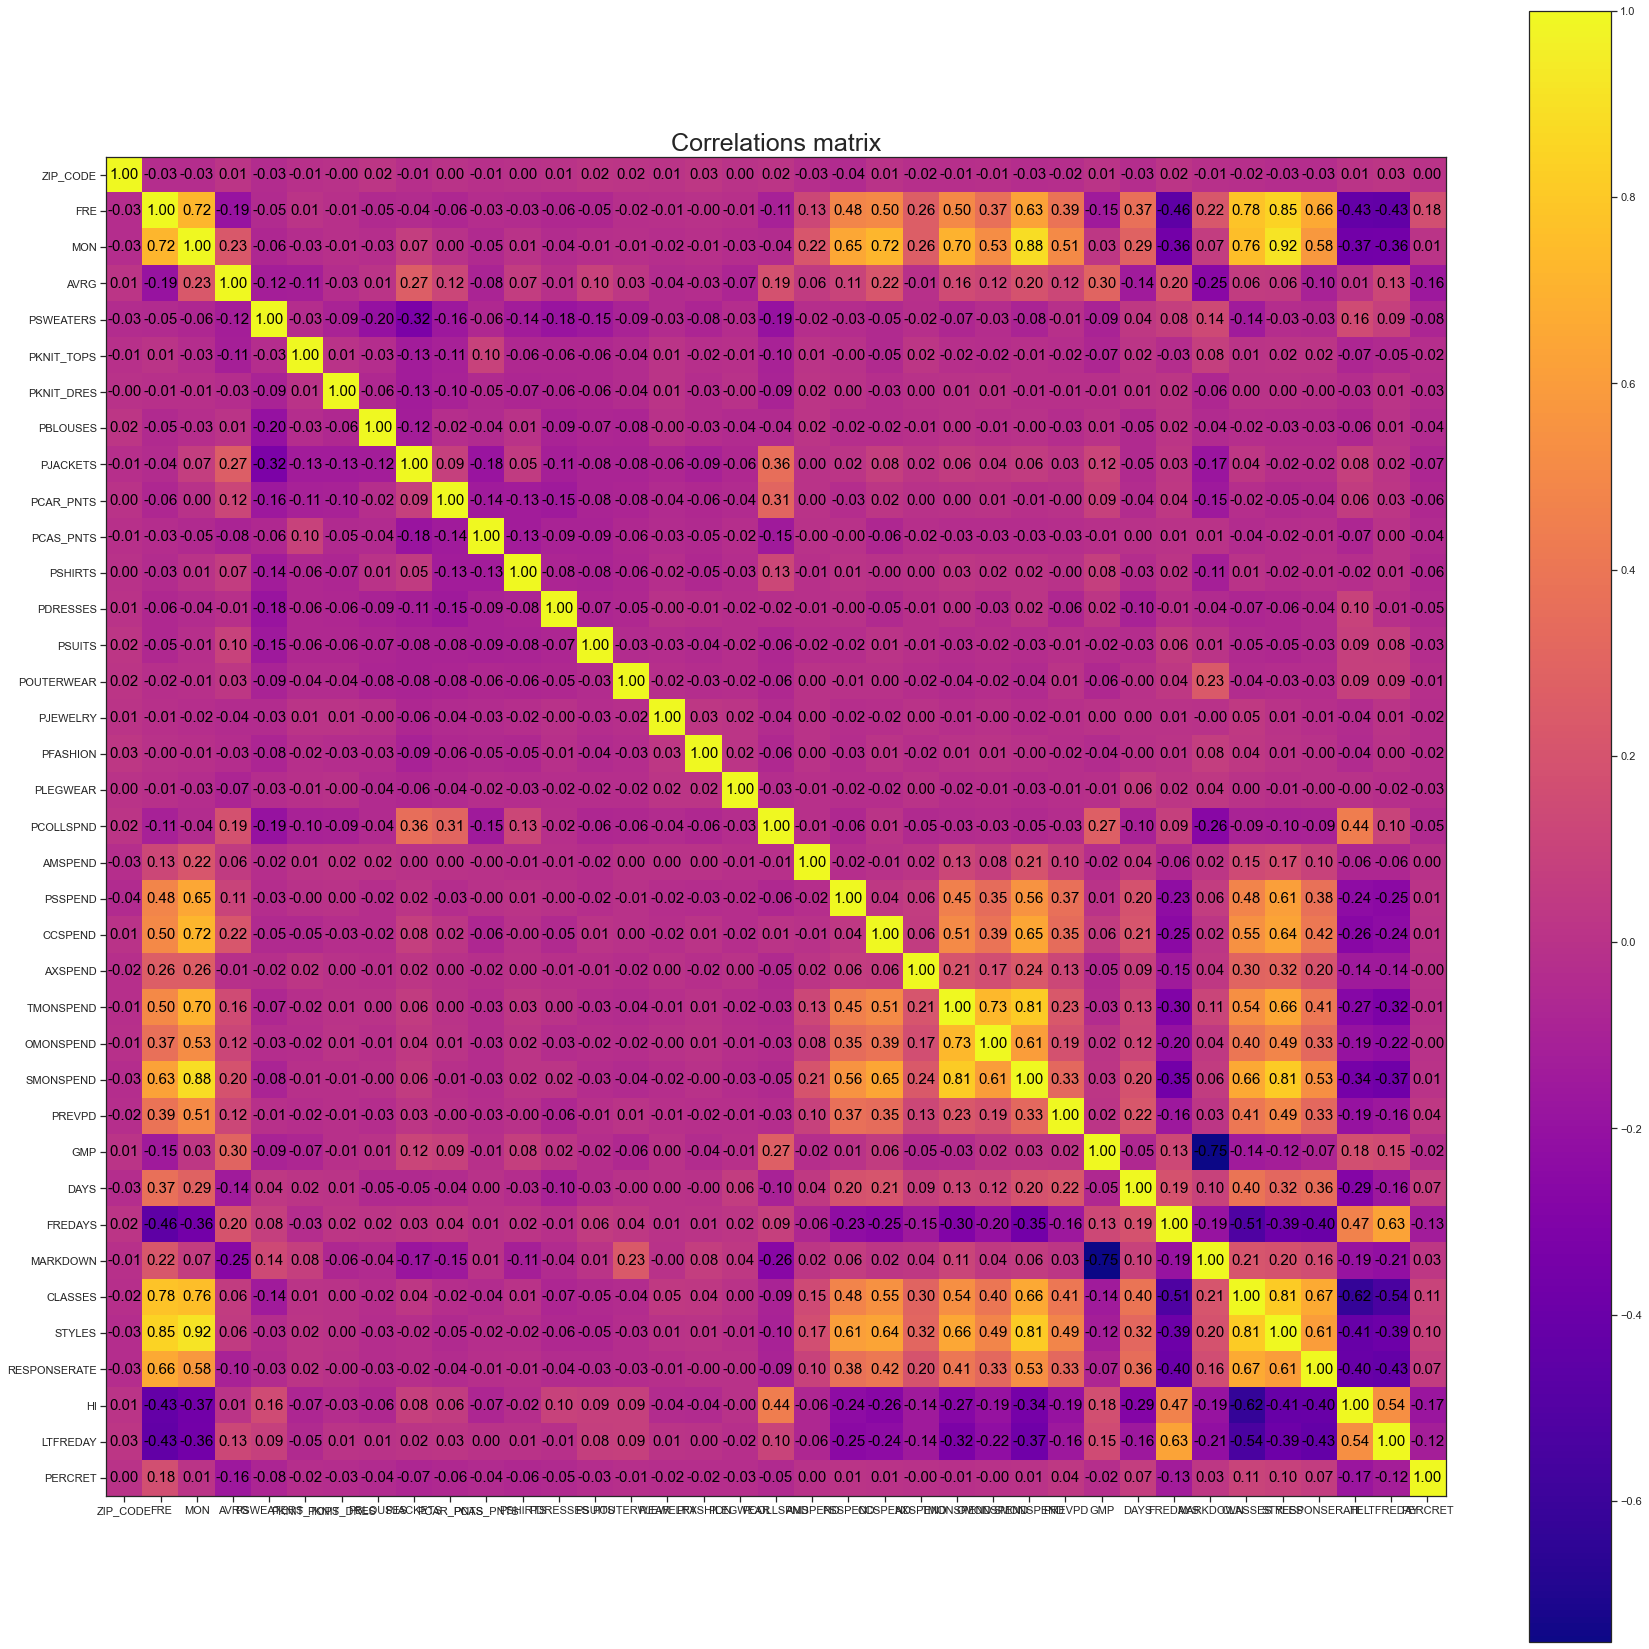

In [65]:
corr=store[continuous_s].corr()
n_var = len(corr) 
plt.figure(figsize=(30,30))
plt.imshow(corr, cmap = 'plasma')

plt.xticks(range(n_var), corr.columns)
plt.yticks(range(n_var), corr.columns)
for i in range(n_var):
    for j in range(n_var):
        plt.text(i, j, '{:.2f}'.format(corr.iloc[i, j]), ha="center", va="center", color="k", fontsize = 15)

plt.colorbar()

plt.title('Correlations matrix',fontsize=25)

plt.savefig('correlation amonge continuous variable.pdf')
plt.show()

couple of things to pointout from this correlation table:<br>
     high correlation between styles:FRE,MON,SMONSPEND,and classes<br>
     high correlation between Mon: TONSPEND,and SMONSPEND<br>
     high correlation among TMONSPEND, OMONSPEND,and SMONSPEND<br> 
     high negative correlation beteween GMP and Markdown 

# Data minning

### `ZIP_CODE (the location of each customer)`

In [39]:
# treat zip code as a categorical variable since it means an area

zip = pd.crosstab(index = store['ZIP_CODE'], columns = 'count')
zip['count'].sort_values(ascending=False)


ZIP_CODE
55125    51
15601    42
60089    38
62301    38
60187    36
         ..
42025     1
41653     1
41647     1
41630     1
99687     1
Name: count, Length: 7419, dtype: int64

We know zip code represents the location of the customers, if there is a way we can group the customer by location, we can explore the relationship between location and sales. For example, we know if two areas are close to each other, their zip code will be very similar. e.g. 2113 North Ryde and 2112 Ryde

i.e. clustering method or box plot of total spend vs. location (zip code)

### `MON (Total net sales)`

In [45]:
total=store['FRE']*store['AVRG']
print('MON  value is ',round(store['MON'].sum(),2))
print('FRE multiplied by AVRG is ', round(total.sum(),2))

MON  value is  10280590.25
FRE multiplied by AVRG is  10280155.28


__we can conclude MON is total spend by each customer, which can be a good indicator for later analysis__

e.g. box plot of xx vs. MON

### `WEB (online shopper)`

Because most people still prefer to go to the actual store, so they can feel the material and see how it looks on them. Only a small proportion of people will choose to shop online. But online shoppers are more likely to respond to our campaign (45%) compare to in-store (15%). Since it is a quicker and more convenient way, they are more likely to respond to our campaign.

### `The most popular product`

<function matplotlib.pyplot.show(close=None, block=None)>

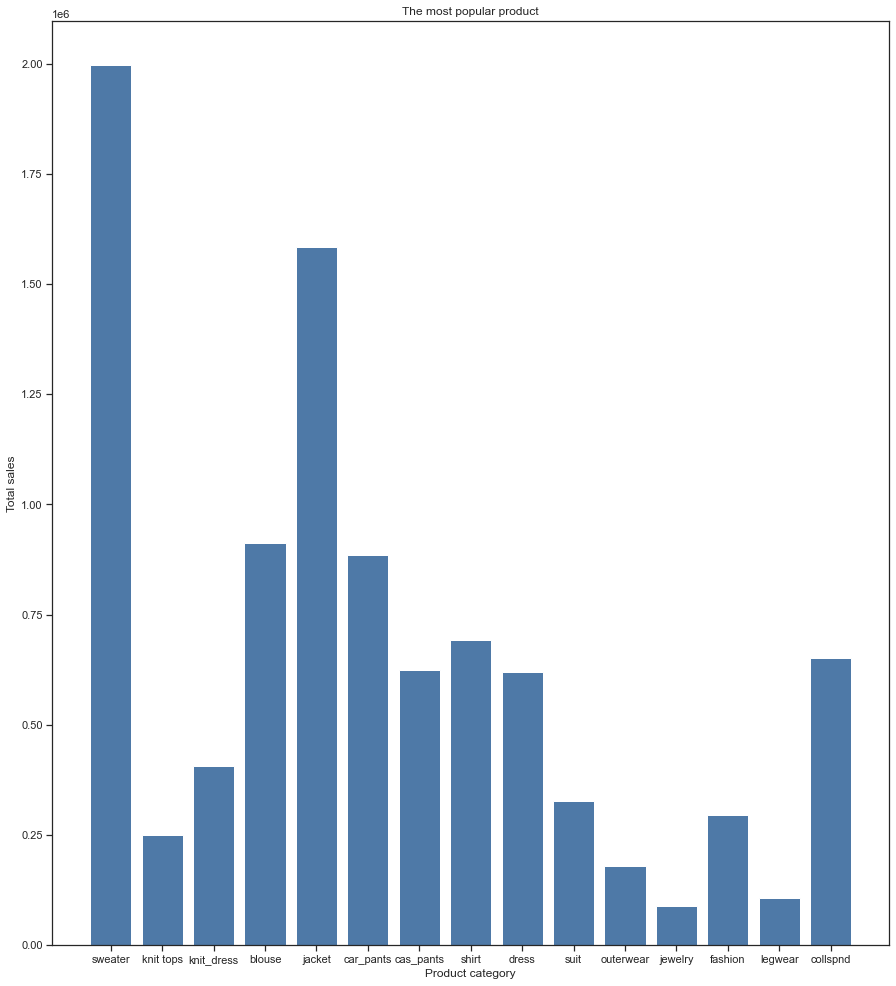

In [52]:
# the most popular product category

store['SWEATERS'] = store['PSWEATERS'] * store['MON']
store['KNIT_TOPS'] = store['PKNIT_TOPS'] * store['MON']
store['KNIT_DRES'] = store['PKNIT_DRES'] * store['MON']
store['BLOUSES'] = store['PBLOUSES'] * store['MON']
store['JACKETS'] = store['PJACKETS'] * store['MON']
store['CAR_PNTS'] = store['PCAR_PNTS'] * store['MON']
store['CAS_PNTS'] = store['PCAS_PNTS'] * store['MON']
store['SHIRTS'] = store['PSHIRTS'] * store['MON']
store['DRESSES'] = store['PDRESSES'] * store['MON']
store['SUITS'] = store['PSUITS'] * store['MON']
store['OUTERWEAR'] = store['POUTERWEAR'] * store['MON']
store['JEWELRY'] = store['PJEWELRY'] * store['MON']
store['FASHION'] = store['PFASHION'] * store['MON']
store['LEGWEAR'] = store['PLEGWEAR'] * store['MON']
store['COLLSPND'] = store['PCOLLSPND'] * store['MON']

a = store['SWEATERS'].sum()
b = store['KNIT_TOPS'].sum()
c = store['KNIT_DRES'].sum()
d=store['BLOUSES'].sum()
e=store['JACKETS'].sum()
f=store['CAR_PNTS'].sum()
g=store['CAS_PNTS'].sum()
h=store['SHIRTS'].sum()
i=store['DRESSES'].sum()
j=store['SUITS'].sum()
k=store['OUTERWEAR'].sum()
l=store['JEWELRY'].sum()
m=store['FASHION'].sum()
n=store['LEGWEAR'].sum()
o=store['COLLSPND'].sum()

x1 = ['sweater', 'knit tops', 'knit_dress', 'blouse', 'jacket', 'car_pants', 'cas_pants', 'shirt', 'dress', 'suit', 'outerwear', 
     'jewelry', 'fashion', 'legwear', 'collspnd']
y1 = [a,b,c,d,e,f,g,h,i,j,k,l,m,n,o]

plt.figure(figsize=(15,17))

plt.bar(x1,y1)
plt.title('The most popular product')
plt.xlabel('Product category')
plt.ylabel('Total sales')
plt.savefig('most popular product')
plt.show

### `The most popular store`

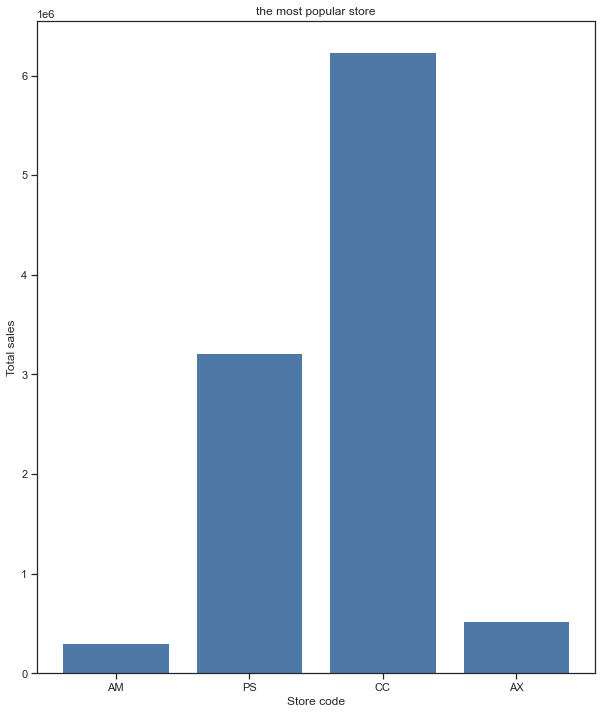

In [53]:
# the most popular store

AM = store['AMSPEND'].sum()
PS = store['PSSPEND'].sum()
CC = store['CCSPEND'].sum()
AX = store['AXSPEND'].sum()

x2 = ['AM', 'PS', 'CC', 'AX']
y2 = [AM, PS, CC, AX]

plt.figure(figsize=(10,12))

plt.bar(x2,y2)
plt.title('the most popular store')
plt.xlabel('Store code')
plt.ylabel('Total sales')
plt.savefig('the most popular store')
plt.show()

# Feature Engineering 

In [ ]:
#Drop features ZIP_CODE, HI, CLUSTYPE, PC_CALC20 since their meaning is not clear

store = store.drop(['ZIP_CODE'], axis=1)
store = store.drop(['HI'], axis=1)
store = store.drop(['CLUSTYPE'], axis=1)
store = store.drop(['PC_CALC20'], axis=1)

In [ ]:
#Drop features that may cause multicolliearity

#Drop AVRG and FRE since MON = AVRG*FRE
store = store.drop(['AVRG'], axis=1)
store = store.drop(['FRE'], axis=1)

#Drop DAYS since FREDAYS = DAY/FRE
store = store.drop(['DAYS'], axis=1)

#Drop FREDAYS since it provides similar information to LTFREDAYS
store = store.drop(['FREDAYS'], axis=1)

#Drop OMONSPEND and TMONSPEND since these are part of SMONSPEND
store = store.drop(['OMONSPEND'], axis=1)
store = store.drop(['TMONSPEND'], axis=1)

#Drop MAIL and RESPONDED since RESPONSERATE = RESPONDED/MAILED
store = store.drop(['MAILED'], axis=1)
store = store.drop(['RESPONDED'], axis=1)

In [ ]:
# encode binary data for VALPHON

store['VALPHON'] = store['VALPHON'].replace(['Y'],1)
store['VALPHON'] = store['VALPHON'].replace(['N'],0)

In [ ]:
# Convert the amount spent at each store to percentage of total and drop originial columns

store['percent_AM']=store['AMSPEND']/store['MON']
store['percent_PS']=store['PSSPEND']/store['MON']
store['percent_CC']=store['CCSPEND']/store['MON']
store['percent_AX']=store['AXSPEND']/store['MON']

store = store.drop(['AMSPEND'], axis=1)
store = store.drop(['PSSPEND'], axis=1)
store = store.drop(['CCSPEND'], axis=1)
store = store.drop(['AXSPEND'], axis=1)

In [ ]:
continuous_s=['MON','PSWEATERS','PKNIT_TOPS','PKNIT_DRES','PBLOUSES','PJACKETS','PCAR_PNTS','PCAS_PNTS','PSHIRTS',
            'PDRESSES','PSUITS','POUTERWEAR','PJEWELRY','PFASHION','PLEGWEAR','PCOLLSPND','SMONSPEND','PREVPD','GMP','MARKDOWN','CLASSES','STYLES','RESPONSERATE',
            'LTFREDAY','PERCRET','percent_AM','percent_PS','percent_CC','percent_AX']
categorical_s=['PROMOS','STORES','COUPONS']
dummies_s=['CC_CARD','VALPHON','WEB']
response_s=['RESP']

In [ ]:
from sklearn.model_selection import train_test_split

index_trainstore, index_validstore  = train_test_split(store.index, train_size=0.7, random_state=546, stratify=store[response_s])

# Write training and validation sets 
train_store = store.loc[index_trainstore, :].copy() 
valid_store =  store.loc[index_validstore, :].copy()

# Response label
response_s = 'RESP'

# Response vectors 
y_trainstore = train_store[response_s]
y_validstore = valid_store[response_s]

In [ ]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

def feat_engineering(store, transformation=True):
    
    store = store.copy()
    
    # Dummy encoding or discrete and categorical variables
    dummies = binary_s[:] # copies list of binary predictors
    labels = categorical_s
    for label in labels:
        features = pd.get_dummies(store[label], prefix=label, drop_first=True)
        store = pd.concat([store,features], axis=1)
        dummies += list(features.columns)
    
    # Yeo-Johnson transformation
    transf = continuous_s
    if transformation: 
        yj_transf = PowerTransformer(method='yeo-johnson').fit(store.loc[index_trainstore, transf])
        store[transf] = yj_transf.transform(store[transf])
    
    # Standardisation
    labels = continuous_s
    scaler = StandardScaler().fit(store.loc[index_trainstore, labels])
    store.loc[:, labels] = scaler.transform(store.loc[:, labels])
    
    predictors_s = continuous_s + dummies_s
    
    X_trainstore = store.loc[index_trainstore, predictors_s]
    X_validstore = store.loc[index_validstore, predictors_s]

    y_trainstore = store.loc[index_trainstore, response_s].to_numpy()
    y_validstore = store.loc[index_validstore, response_s].to_numpy()
    
    return X_trainstore, np.ravel(y_trainstore), X_validstore, np.ravel(y_validstore), predictors_s

X_trainstore, y_trainstore, X_validstore, y_validstore, predictors_s = feat_engineering(store)


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='l1', solver='liblinear') # using a different solver to avoid numerical errors
x1=logit.fit(X_trainstore, y_trainstore)

In [ ]:
tau=0.5

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, log_loss
from sklearn.metrics import accuracy_score

columns=['Estimated risk', 'SE', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy']
rows=['Logistic Regression', 'KNN']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit]

y_probstore = np.zeros((len(y_validstore), len(rows)))

for i, method in enumerate(methods):    
    
    y_probstore[:,i] = method.predict_proba(X_validstore)[:,1]
    y_predstore = (y_probstore[:,i] > tau).astype(int)

    loss =  5*((y_predstore!=y_validstore) & (y_predstore==0)) + 1*((y_predstore!=y_validstore) & (y_predstore==1))

    tn, fp, fn, tp = confusion_matrix(y_validstore, y_predstore).ravel() 

    results.iloc[i,0] =  np.mean(loss) # or (fp*1+fn*5)/len(y_test)
    results.iloc[i,1] =  np.std(loss)/np.sqrt(len(loss))
    results.iloc[i,2] =  accuracy_score(y_validstore, y_predstore)
    results.iloc[i,3] =  tp/(tp+fn)
    results.iloc[i,4] =  tn/(tn+fp)
    results.iloc[i,5] =  precision_score(y_validstore, y_predstore)
    results.iloc[i,6] =  roc_auc_score(y_validstore, y_probstore[:,i])
    results.iloc[i,7] =  log_loss(y_validstore, y_probstore[:,i])

results.round(3)

In [ ]:
# Submission code

In [ ]:
# method 1
X_eval = test_set[feature_names].values
stack.fit(X, y)
y_eval_pred = stack.predict(X_eval)
submit = {
    "Id": test_set["Id"].tolist(),
    "price": np.exp(y_eval_pred).tolist()
}
submission = pd.DataFrame(submit)
submission.set_index('Id',inplace=True)
submission

In [ ]:
# method 2
final_pred_rf = rf.predict(df3_test)
submission = pd.DataFrame()
submission['price'] = np.exp(final_pred_rf)
submission['Id'] = df3_test_Id
submission.to_csv('kaggle_submission_Random Forest.csv', index =False)
submission = submission[['Id','price']]
submission